# ML model:

### MLP classifier

### 200 files

### no keywords

In [1]:
# === MODELL SPEICHERN ===
prefix = "mlp_200_nokey"
clf_file = f"prometainfer/models/{prefix}_model.pkl"
p_file = f"prometainfer/models/{prefix}_preprocessor.pkl"
enc_file = f"prometainfer/models/{prefix}_label_encoders.pkl"
train_features = f"prometainfer/models/{prefix}_train_features.csv"

In [2]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer  # For handling NaNs
import joblib

In [3]:
import os
import re
import pandas as pd
from pathlib import Path

# === 1. EXTRACT FEATURES FROM OpenMS FILEINFO TXT FILES ===
def extract_features_from_txt(file_path):
    """Extracts features from an OpenMS FileInfo text file."""
    features = {
        "instrument_model": "Not available",
        "organism": "Not available",
        "tissue": "Not available",
        "disease": "Not available",
        "software": "Not available",
        "activation_method": "",
        "experiment_type": "Not available",
        "fraction_identifier": "Not available",
        "quantification_method": "Not available",
        "cleavage_agent": "Not available",
    }

    with open(file_path, "r") as f:
        content = f.readlines()
    
    if not content:
        print("empty file")

    for line in content:
        line = line.strip()

        # Extract retention time range
        if "retention time:" in line:
            match = re.findall(r"([\d\.]+)", line)
            if len(match) == 2:
                features["rt_min"] = float(match[0])
                features["rt_max"] = float(match[1])
        
        # Extract mass-to-charge (m/z) range
        elif "mass-to-charge:" in line:
            match = re.findall(r"([\d\.]+)", line)
            if len(match) == 2:
                features["mz_min"] = float(match[0])
                features["mz_max"] = float(match[1])
        
        # Extract intensity range
        elif "intensity:" in line:
            match = re.findall(r"([\d\.e\+]+)", line)  # Handle scientific notation
            if len(match) == 2:
                features["intensity_min"] = float(match[0])
                features["intensity_max"] = float(match[1])
        
        # Extract precursor charge distribution
        elif "charge" in line and "x" in line:
            match = re.search(r"charge (\d+): (\d+)x", line)
            if match:
                charge, count = int(match.group(1)), int(match.group(2))
                features[f"precursor_charge_{charge}"] = count
        
        # Extract instrument model
        elif "Instrument:" in line:
            if features["instrument_model"] == "Not available":
                if(line.split("Instrument: ")[-1].strip() != "Instrument:"):
                    features["instrument_model"] = line.split("Instrument: ")[-1].strip()
        
        # Extract total number of peaks
        elif "Total number of peaks:" in line:
            match = re.search(r"(\d+)", line)
            if match:
                features["total_peaks"] = int(match.group(0))
        
        # Extract number of spectra
        elif "Number of spectra:" in line:
            match = re.search(r"(\d+)", line)
            if match:
                features["num_spectra"] = int(match.group(0))
        
        # Extract organism, tissue, and disease (if available)
        elif "organism:" in line.lower():
            if line.split(": ")[-1].strip() != 'organism:':
                features["organism"] = line.split(": ")[-1].strip() 
        elif "tissue:" in line.lower():
            features["tissue"] = line.split(": ")[-1].strip()
        elif "disease:" in line.lower():
            features["disease"] = line.split(": ")[-1].strip()
        
        # Extract software information
        elif "software name:" in line.lower():
            if(line.split(": ")[-1].strip() != 'software name:'):
                features["software"] = line.split(": ")[-1].strip()

        elif(features["activation_method"] == 'Not available'):
            features["activation_method"] = line.split(':')[0].split("MS-Level 2 & ")[-1].strip()
        
        # Extract activation method
        elif "activation methods" in line.lower():
            features["activation_method"] = 'Not available'
        
        # Extract experiment type (e.g., bottom-up, top-down)
        elif "experiment type:" in line.lower():
            features["experiment_type"] = line.split(": ")[-1].strip()
        
        # Extract fraction identifier
        elif "fraction identifier:" in line.lower():
            features["fraction_identifier"] = line.split(": ")[-1].strip()
        
        # Extract quantification method
        elif "quantification:" in line.lower():
            features["quantification_method"] = line.split(": ")[-1].strip()
        
        # Extract cleavage agent details
        elif "cleavage agent:" in line.lower():
            features["cleavage_agent"] = line.split(": ")[-1].strip()
    if(features["activation_method"] == ""):
        features["activation_method"] = "Not available"
    return features

# === 2. PROCESS ALL FILEINFO TXT FILES ===
txt_folders = ["../data/ML_test/fileinfo_files"]
data = []

for folder in txt_folders:
    folder_path = Path(folder)
    for txt_file in folder_path.glob("*"):  # Iterate over all files
        features = extract_features_from_txt(txt_file)
        features["Filename"] = str(txt_file).split("/")[-1]+".mzML"#.split('_fileinfo')[0].split('txts/')[-1]  # Convert filename for matching
        data.append(features)

# Convert to DataFrame
features_df = pd.DataFrame(data)

In [4]:
# load metadata and merge with features
metadata = pd.read_csv("../data/metadata/prot_ids_and_pride_meta.csv")
df = metadata.merge(features_df, on="Filename", how="inner")

# load parsed keywords
#keywords_file = "../data/ML_test/keyword_files/keyword_parsing_results.csv"
#keywords_df = pd.read_csv(keywords_file)
#df = keywords_df.merge(df, on="Filename", how="inner")

# preprocessing
label_columns = ["Organism", "Organism part", "Diseases", "Modification", "Instrument","Software",
                 "Experiment Type","Quantification"]
df[label_columns] = df[label_columns].fillna("Not available")
df[label_columns]

,Organism,Organism part,Diseases,Modification,Instrument,Software,Experiment Type,Quantification
0,Mus musculus (mouse),"Cortex of kidney, Kidney",Renal cell carcinoma,"monohydroxylated residue, acetylated residue, ...",Orbitrap Fusion Lumos,"SEQUEST, Proteome Discoverer, Percolator",Shotgun proteomics,precursor ion
1,"Trypanosoma brucei brucei, Leishmania major st...",Not available,Not available,No PTMs are included in the dataset,Orbitrap Fusion Lumos,Not available,Shotgun proteomics,Not available
2,Mus musculus (mouse),Cell culture,Not available,No PTMs are included in the dataset,LTQ Orbitrap Velos,Mascot,Gel-based experiment,Not available
3,Homo sapiens (human),"Epithelial cell, Early embryonic cell",Not available,methylthiolated residue,Q Exactive,Not available,Affinity purification coupled with mass spectr...,Not available
4,Escherichia coli,Not available,Not available,No PTMs are included in the dataset,Q Exactive,Not available,RNA mass spectrometry,Not available
...,...,...,...,...,...,...,...,...
389,Homo sapiens (human),"Substantia nigra, Brain, Dopaminergic neuron",Not available,"monohydroxylated residue, deamidated residue, ...",Orbitrap Fusion Lumos,"Andromeda, MaxQuant",Shotgun proteomics,MS1 intensity based label-free quantification ...
390,Homo sapiens (human),"Cell culture, Brain",Human immunodeficiency virus infectious disease,"monohydroxylated residue, TMT6plex-126 reporte...",Q Exactive,Not available,Shotgun proteomics,TMT
391,"Homo sapiens (human), Mus musculus (mouse)",Not available,Not available,"Gln->pyro-Glu, Carbamyl, TMT6plex, Deamidated,...",Q Exactive,"2.2.0.388 2.2.0.388, Mascot Server 2.4.1, Masc...",Shotgun proteomics,TMT
392,Homo sapiens (human),Brain,Alzheimer's disease,"monohydroxylated residue, phosphorylated resid...",LTQ Orbitrap Velos,Mascot,Shotgun proteomics,Spectrum counting


In [5]:
### Eucaryote/ Bacteria/ Virus prediction -- Generate labels

domain_mapping = {
    "Homo sapiens (human)": "Eukaryota",
    "Mus musculus (mouse)": "Eukaryota",
    "Arabidopsis thaliana (mouse-ear cress)": "Eukaryota",
    "Escherichia coli": "Bacteria",
    "Rattus norvegicus (rat)": "Eukaryota",
    "Saccharomyces cerevisiae (baker's yeast)": "Eukaryota",
    "Plasmodium berghei anka": "Eukaryota",
    "Bos taurus (bovine)": "Eukaryota",
    "Brassica oleracea var. botrytis (cauliflower)": "Eukaryota",
    "Danio rerio (zebrafish) (brachydanio rerio)": "Eukaryota",
    "Gallus gallus (chicken)": "Eukaryota",
    "Apis mellifera (honeybee)": "Eukaryota",
    "Naja melanoleuca": "Eukaryota",
    "Deinococcus radiodurans r1": "Bacteria",
    "Kalanchoe fedtschenkoi": "Eukaryota",
    "Toxoplasma gondii rh": "Eukaryota",
    "Phaeodactylum tricornutum (strain ccap 1055/1)": "Eukaryota",
    "Mycobacterium avium 104": "Bacteria",
    "Elysia crispata": "Eukaryota",
    "Phormidium sp. oscr": "Bacteria",
    "Norovirus": "Virus",
    "Caenorhabditis elegans": "Eukaryota",
    "Saccostrea glomerata": "Eukaryota",
    "Botryotinia fuckeliana (noble rot fungus) (botrytis cinerea)": "Eukaryota",
    "Candida glabrata (yeast) (torulopsis glabrata)": "Eukaryota",
    "Giardia lamblia atcc 50803": "Eukaryota",
    "Triticum aestivum (wheat)": "Eukaryota",
    "Streptomyces coelicolor": "Bacteria",
    "Coffea canephora": "Eukaryota",
    "Hordeum vulgare (barley)": "Eukaryota",
    "Pisum sativum (garden pea)": "Eukaryota",
    "Brugia malayi": "Eukaryota",
    "Plasmodium vivax": "Eukaryota",
    "Prochlorococcus marinus subsp. pastoris str. ccmp1986": "Bacteria",
    "Cupriavidus necator (strain atcc 17699 / h16 / dsm 428 / stanier 337) (ralstonia eutropha)": "Bacteria",
    "Nicotiana tabacum (common tobacco)": "Eukaryota",
    "Chlamydomonas reinhardtii": "Eukaryota",
    "Sus scrofa domesticus (domestic pig)": "Eukaryota",
    "Pinus pinaster (maritime pine)": "Eukaryota",
    "Emiliania huxleyi": "Eukaryota",
    "Plasmodium berghei": "Eukaryota",
    "[candida] glabrata cbs 138": "Eukaryota",
    "Trichuris suis": "Eukaryota",
    "Methanothrix soehngenii gp6": "Archaea",
    "Clostridium cellulolyticum (strain atcc 35319 / dsm 5812 / jcm 6584 / h10)": "Bacteria",
    "Methanospirillum hungatei jf-1": "Archaea",
    "Desulfovibrio vulgaris str. hildenborough": "Bacteria",
    "Haloferax volcanii (halobacterium volcanii)": "Archaea",
    "Trypanosoma brucei brucei, Leishmania major strain friedlin": "Eukaryota",
    "Toxoplasma gondii": "Eukaryota",
    "Synechococcus sp. (strain wh8102)": "Bacteria",
    "Cryptococcus neoformans var. grubii vni" : "Eukaryota",
    "Rupicapra pyrenaica, Ovis aries musimon, Capra pyrenaica" : "Eukaryota",
    "Streptococcus pyogenes stab901":"Bacteria",
    "Bemisia sp. unknown_th_13_12_s.lycopersicum": "Eukaryota"
}

# Funktion zur Ermittlung der Domain
def get_domain(organism):
    domains = set()
    for key, value in domain_mapping.items():
        if key in organism:
            domains.add(value)
    return ", ".join(domains) if domains else "Unknown"


df["Domain"] = df["Organism"].apply(get_domain)

df[["Organism", "Domain"]].to_csv("../data/metadata/domains.csv")

label_columns = ["Domain","Organism", "Organism part", "Diseases", "Modification", 
                 "Experiment Type", "Instrument", "Quantification", "Software"]

In [6]:
# only keep files for which peptide id could be calculated
idxml_dir = "../data/ML_test/swissprot_ids"

# Process all idXML files in the specified directory
pep_filenames = []
for file in os.listdir(idxml_dir):
    mzML_filename = file.split("_CometAdapter.idXML")[0] + ".mzML"
    pep_filenames.append(mzML_filename)

print(len(pep_filenames))

df = df[df["Filename"].isin(pep_filenames)]

df.shape

165


(157, 5601)

In [7]:
pep_id_df = df.drop(columns=["Filename", "PRIDE ID", "Unnamed: 0", "Submission Date",
                     "Publication Date", "Country", "Keywords"] + label_columns)

pep_id_df.to_csv(train_features, index = False)

In [ ]:
# Best Parameters: {'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (50,), 'estimator__max_iter': 300}
label_encoders = {col: LabelEncoder() for col in label_columns}
for col in label_columns:
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Features & Labels splitten
X = df.drop(columns=["Filename", "PRIDE ID", "Unnamed: 0", "Submission Date",
                     "Publication Date", "Country", "Keywords"] + label_columns)
y = df[label_columns]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Create a ColumnTransformer to preprocess categorical and numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        # Impute NaNs in numeric columns with the mean, then scale
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),  # Impute NaNs with mean
            ("scaler", StandardScaler())  # Scale numeric columns
        ]), numeric_cols),
        
        # Impute NaNs in categorical columns with the most frequent value, then one-hot encode
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),  # Impute NaNs with mode
            ("onehot", OneHotEncoder(handle_unknown="ignore"))  # One-hot encode categorical columns
        ]), categorical_cols),
    ]
)

# Apply preprocessing to X
X_preprocessed = preprocessor.fit_transform(X)

# === 5. MACHINE LEARNING MODELL TRAINIEREN ===
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Multi-Output MLPClassifier
USEMLP=True
if USEMLP:
    rf = MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42, alpha = 0.0001)
else:
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
multi_output_clf = MultiOutputClassifier(rf)

# Best Parameters: {'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (50,), 'estimator__max_iter': 300}

multi_output_clf.fit(X_train, y_train)

y_pred = multi_output_clf.predict(X_test)

for i, col in enumerate(label_columns):
    print(f"Classification Report for {col}:")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))

joblib.dump(multi_output_clf, clf_file)
joblib.dump(preprocessor, p_file)
joblib.dump(label_encoders, enc_file)

/mnt/volume/bin/miniconda3/envs/ms1connect_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/volume/bin/miniconda3/envs/ms1connect_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/volume/bin/miniconda3/envs/ms1connect_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/volume/bin/miniconda3/envs/ms1connect_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and 

Classification Report for Domain:
              precision    recall  f1-score   support

           0       0.38      0.50      0.43         6
           2       0.83      0.65      0.73        23
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         0

    accuracy                           0.56        32
   macro avg       0.24      0.23      0.23        32
weighted avg       0.67      0.56      0.61        32

Classification Report for Organism:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           9       0.40      0.67      0.50         3
          11       0.00      0.00      0.00         1
          12       0.50      0.43      0.46        14
        

/mnt/volume/bin/miniconda3/envs/ms1connect_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


['prometainfer/models/mlp_200_nokey_label_encoders.pkl']

##### Test for Automation: give out predictions + estimated ML metrics

In [9]:
y_pred_decoded = pd.DataFrame(y_pred, columns=label_columns)
y_pred_decoded["Diseases"].values
label_encoders["Diseases"].inverse_transform([12])

array(['Not available'], dtype=object)

In [ ]:
#decode predictions
y_pred_decoded = pd.DataFrame(y_pred, columns=label_columns)

for i, col in enumerate(label_columns):
    y_pred_decoded[col] = label_encoders[col].inverse_transform(y_pred[:, i])

print(y_pred_decoded.head())

      Domain              Organism                    Organism part  \
0  Eukaryota  Homo sapiens (human)                    Not available   
1  Eukaryota   Bos taurus (bovine)                    Not available   
2   Bacteria      Naja melanoleuca                    Not available   
3  Eukaryota  Homo sapiens (human)                     Cell culture   
4  Eukaryota      Plasmodium vivax  Blood, Blood cell, Blood plasma   

                        Diseases  \
0                  Not available   
1      Degenerative disc disease   
2  Juvenile rheumatoid arthritis   
3                  Breast cancer   
4       Plasmodium vivax malaria   

                                        Modification  \
0  monohydroxylated residue, deamidated residue, ...   
1  monohydroxylated residue, complex glycosylatio...   
2  L-methionine sulfoxide, S-carboxamidomethyl-L-...   
3                             phosphorylated residue   
4                  iodoacetamide derivatized residue   

                   

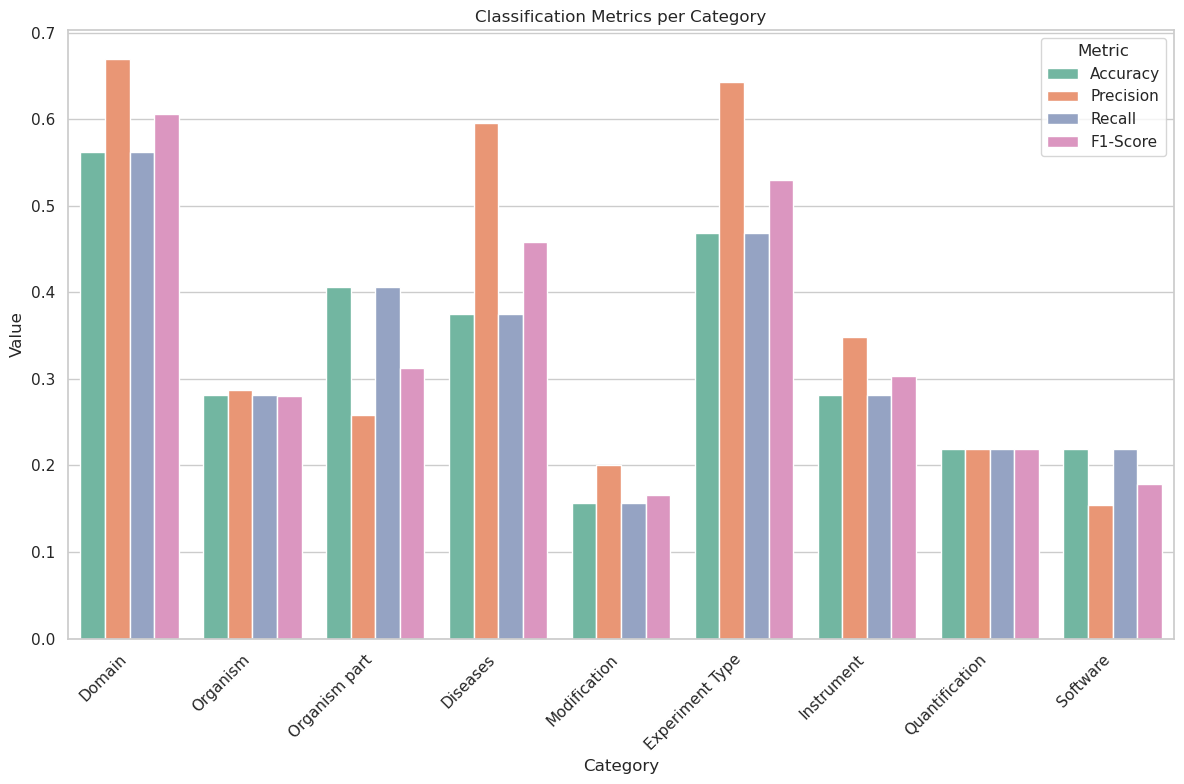

In [ ]:
### Weighted average scores

### Without parsed keywords included, incl. gridsearchcv (5-fold-cross validation)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

joblib.dump(classification_report, "../data/ML_test/clrep_m02_200.pkl")
joblib.dump(y_test, "../data/ML_test/y_test_m02_200.pkl")
joblib.dump(y_pred, "../data/ML_test/y_pred_m02_200.pkl")
classification_report = joblib.load("../data/ML_test/clrep_m02_200.pkl")

metrics_data = []

# Classification Report per metadata category
for i, col in enumerate(label_columns):
    report = classification_report(y_test.iloc[:, i], y_pred[:, i], output_dict=True, zero_division=0)
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    
    metrics_data.append([col, "Accuracy", accuracy])
    metrics_data.append([col, "Precision", report["weighted avg"]["precision"]])
    metrics_data.append([col, "Recall", report["weighted avg"]["recall"]])
    metrics_data.append([col, "F1-Score", report["weighted avg"]["f1-score"]])

# DataFrame erstellen
df_metrics = pd.DataFrame(metrics_data, columns=["Category", "Metric", "Value"])

# Farbpalette generieren
categories = df_metrics["Category"].unique()
full_palette = sns.color_palette("muted", len(categories) + 2)
filtered_palette = [color for color in full_palette if max(color) - min(color) > 0.15]
custom_palette = {cat: "#DCDCDC" if cat in ["Diseases", "Experiment Type"] else filtered_palette[i] for i, cat in enumerate(categories)}

# Plot erstellen
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

sns.barplot(x="Category", y="Value", hue="Metric", data=df_metrics, palette="Set2")
plt.title("Classification Metrics per Category")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Metric", loc="upper right")

# Layout anpassen
plt.tight_layout()
plt.savefig(f"../results/figures/ML_approach/{prefix}_classification_metrics_per_category_weighted.pdf")
plt.show()
